<a href="https://colab.research.google.com/github/SenpaiSepehr/DeepLearning/blob/main/SepClassifier_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Library & Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

from torchvision.datasets import CIFAR100
from tqdm import tqdm

####DataLoader

In [2]:
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
#transforming training set.
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.RandomRotation(degrees=15),
    #tt.RandomResizedCrop(size=32, scale=(0.8,1.0), ratio=(0.8,1.2)),
    tt.ToTensor(),        # 3 channels: RGB, tensor.size=[3*32*32]
    tt.Normalize(*stats)  # to ensure gradients don't diverge
])
#transforming test set
val_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats) 
])

train_data = CIFAR100(download=True, root="./data", transform=train_transform)
val_data = CIFAR100(root="./data", train=False, transform=val_transform)

def load_data(batch_size):
    train_loader = DataLoader(train_data,batch_size=batch_size, num_workers=2,
                          pin_memory=True, shuffle=True)
    
    val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=2,
                        pin_memory=True)
    
    return train_loader, val_loader

Files already downloaded and verified


####Resnet18 <font color='red'>**Scratch Model**</font>

In [3]:
from torch import Tensor
from typing import Type

class BasicBlock (nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, expansion=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.expansion = expansion
    self.downsample = downsample
    self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=stride,
                           padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels,out_channels*self.expansion,
                           kernel_size=3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    
    if self.downsample is not None: identity = self.downsample(x)
    out += identity
    out = self.relu(out)
    return out

class ResNet18(nn.Module):
  def __init__(self, img_channels, num_layers,block,num_classes=1000):
    super(ResNet18,self).__init__()
    if num_layers == 18:
      layers = [2,2,2,2]
      self.expansion = 1
    
    self.in_channels = 64
    self.conv1 = nn.Conv2d(in_channels = img_channels, 
                           out_channels=self.in_channels,kernel_size=7,stride=2,
                           padding=3,bias=False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block,64,layers[0])
    self.layer2 = self._make_layer(block,128,layers[1], stride=2)
    self.layer3 = self._make_layer(block,256,layers[2], stride=2)
    self.layer4 = self._make_layer(block,512,layers[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*self.expansion,num_classes)

  def _make_layer(self,block,out_channels,blocks,stride=1) -> nn.Sequential:
    downsample = None
    if stride != 1:
      downsample = nn.Sequential(nn.Conv2d(self.in_channels,
                                           out_channels*self.expansion,
                                           kernel_size=1,stride=stride,bias=False)
      ,nn.BatchNorm2d(out_channels*self.expansion),)
    layers = []
    layers.append(block(self.in_channels, out_channels, stride,self.expansion,
                        downsample))
    self.in_channels = out_channels*self.expansion

    for i in range(1, blocks):
      layers.append(block(self.in_channels, out_channels, expansion=self.expansion))
    return nn.Sequential(*layers)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    #print('Dimensions of the last convolutional feature map: ', x.shape)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)

    return x

####Plot <font color='red'>**Matlib**</font>

In [4]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

####Training Module

In [5]:
def train(model, trainloader, optimizer, criterion, scheduler, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0

    for i, data in tqdm(enumerate(trainloader), total=len(trainloader),
                        ncols=35, bar_format='\033[35m{l_bar}{bar}\033[0m'):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(image)

        # Calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()

        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()

        # Backpropagation
        loss.backward()
        
        # Update the weights
        optimizer.step()

        # Update the learning-rate
        #scheduler.step()
    
    # Loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

####Test Module

In [6]:
def validate(model, testloader, criterion, device):
    model.eval()
    print('\n'+'Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader),
                            ncols=35, bar_format='\033[36m{l_bar}{bar}\033[0m'):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # Forward pass.
            outputs = model(image)

            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

####Seed

In [7]:
import random
# Set seed.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

####Choosing Model <font color='red'>**ResNet18** </font><font color='green'>**EfficientNet-B0**</font>

In [8]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# args = {
#     'model': 'pretrainedEfficientNetB0'
# }

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# if args['model'] == 'ResNet18':
#     print('[INFO]: Initiating ResNet18')
#     model = ResNet18(img_channels=3, num_layers=18,
#                      block=BasicBlock, num_classes=100).to(device)
#     plot_name = 'ResNet18 - CIFAR100'

# if args['model'] == 'EfficientNetB0':
#     print('[INFO]: Initiating EfficientnetB0')
#     model = models.efficientnet_b0(num_classes=100).to(device)
#     plot_name = 'EfficientNetB0 - CIFAR100'

# if args['model'] == 'pretrainedEfficientNetB0':
#     print('[INFO]: Initiating pretrained EfficientnetB0')
#     model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=100).to(device)
#     plot_name = 'Pretrained EfficientNetB0 - CIFAR100'

####Hyper-Param Tuning <font color='red'>**Optuna**</font>



In [10]:
# !pip install optuna
# !pip install tensorboard
# from torch.utils.tensorboard import SummaryWriter
# import optuna
# import time

# %load_ext tensorboard
# writer = SummaryWriter(log_dir='logs')

# criterion = nn.CrossEntropyLoss()   # Not tuning

# batch_size = 256
# train_loader, val_loader = load_data(batch_size)

# epochs = 20                         
# trial_num = 0

# def objective(trial):
#     global trial_num
#     # Define hyperparameters
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
#     weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

#     # Update optimizer and scheduler
#     optimizer = optim.RMSprop(model.parameters(), lr=learning_rate,
#                           weight_decay=weight_decay, momentum=0.9)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs,
#                                                    steps_per_epoch=len(train_loader))
    
#     highest_acc = 0.0
#     # Train and evaluate the model
#     for epoch in range(epochs):

#       print(f"\n -----[ Trial: {trial_num+1} <> Epoch: {epoch+1} ]-----")

#       train_loss, train_acc = train(model, train_loader, optimizer, criterion, device,
#                                     weight_decay, scheduler)
#       writer.add_scalar('Loss/train', train_loss,trial_num)
#       writer.add_scalar('Accuracy/train', train_acc,trial_num)

#       start_time = time.time()
#       valid_loss, valid_acc = validate(model, val_loader, criterion, device)
#       writer.add_scalar('Loss/test', valid_loss, trial_num)
#       writer.add_scalar('Accuracy/test', valid_acc, trial_num) 
#       end_time = time.time()
#       inference = end_time - start_time

#       print(f"\nTraining loss: {train_loss:.2f}, Training acc: {train_acc:.1f}")
#       print(f"Validation loss: {valid_loss:.2f}, Validation acc: {valid_acc:.1f}")
#       print(f"Inference time: {inference:.2f} seconds")

#       # Finding the most accurate iteration
#       if valid_acc > highest_acc:
#         highest_acc = valid_acc
#         best_epoch = epoch + 1

#       if epoch == epochs-1:
#         print(f"Highest validation accuracy achieved: {highest_acc:.1f} at epoch {best_epoch}")
#         highest_acc = 0

#     trial_num += 1

#     # Report the objective value(Accuracy) to Optuna
#     return valid_acc

# # Set up the Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=4)

# # Access the best hyperparameters and objective value
# best_params = study.best_params
# best_value = study.best_value
# writer.close()
# print("Best hyperparameters:", best_params)
# print("Best objective value:", best_value)

# %tensorboard --logdir logs


####Loading Model <font color='red'>**Pre-trained Weights**</font>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

args = {
    'model': 'pretrainedEfficientNetB0'
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if args['model'] == 'ResNet18':
  model = ResNet18(img_channels=3, num_layers=18,
                   block=BasicBlock, num_classes=100).to(device)
  model.load_state_dict(torch.load(
      '/content/drive/My Drive/Colab Notebooks/ResNet18_SGD.pth'))
  
if args['model'] == 'pretrainedEfficientNetB0':
  model = EfficientNet.from_pretrained(
      'efficientnet-b0', num_classes=100).to(device)
  model.load_state_dict(torch.load(
      '/content/drive/My Drive/Colab Notebooks/Enet_Stage2.pth'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded pretrained weights for efficientnet-b0


####Execution

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 33, 33]               0
Conv2dStaticSamePadding-2           [-1, 32, 16, 16]             864
       BatchNorm2d-3           [-1, 32, 16, 16]              64
MemoryEfficientSwish-4           [-1, 32, 16, 16]               0
         ZeroPad2d-5           [-1, 32, 18, 18]               0
Conv2dStaticSamePadding-6           [-1, 32, 16, 16]             288
       BatchNorm2d-7           [-1, 32, 16, 16]              64
MemoryEfficientSwish-8           [-1, 32, 16, 16]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 

100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 1.24, Training acc: 64.4
Validation loss: 1.43, Validation acc: 61.1
Inference time: 3.19 seconds
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 1.13, Training acc: 66.9
Validation loss: 1.43, Validation acc: 61.5
Inference time: 3.18 seconds
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 1.09, Training acc: 68.4
Validation loss: 1.43, Validation acc: 61.3
Inference time: 5.51 seconds
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 1.06, Training acc: 69.1
Validation loss: 1.43, Validation acc: 61.4
Inference time: 4.23 seconds
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 1.04, Training acc: 69.9
Validation loss: 1.43, Validation acc: 61.7
Inference time: 3.18 seconds
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 1.02, Training acc: 70.5
Validation loss: 1.41, Validation acc: 61.9
Inference time: 3.03 seconds
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 1.00, Training acc: 71.1
Validation loss: 1.41, Validation acc: 61.7
Inference time: 3.04 seconds
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.98, Training acc: 71.6
Validation loss: 1.41, Validation acc: 62.0
Inference time: 3.09 seconds
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.96, Training acc: 72.2
Validation loss: 1.42, Validation acc: 62.1
Inference time: 2.96 seconds
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.94, Training acc: 72.5
Validation loss: 1.41, Validation acc: 62.5
Inference time: 3.05 seconds
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.93, Training acc: 73.1
Validation loss: 1.41, Validation acc: 62.1
Inference time: 3.01 seconds
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.92, Training acc: 73.1
Validation loss: 1.40, Validation acc: 62.4
Inference time: 3.19 seconds
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████



Training loss: 0.89, Training acc: 73.9
Validation loss: 1.40, Validation acc: 62.3
Inference time: 3.85 seconds
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.88, Training acc: 74.1
Validation loss: 1.40, Validation acc: 62.1
Inference time: 4.95 seconds
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.87, Training acc: 74.6
Validation loss: 1.40, Validation acc: 62.5
Inference time: 4.35 seconds
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.85, Training acc: 74.9
Validation loss: 1.40, Validation acc: 62.3
Inference time: 3.34 seconds
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.83, Training acc: 75.7
Validation loss: 1.40, Validation acc: 62.4
Inference time: 2.97 seconds
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.83, Training acc: 75.6
Validation loss: 1.40, Validation acc: 62.4
Inference time: 3.12 seconds
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.82, Training acc: 76.0
Validation loss: 1.40, Validation acc: 62.6
Inference time: 3.01 seconds
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.80, Training acc: 76.4
Validation loss: 1.40, Validation acc: 62.6
Inference time: 2.97 seconds
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.79, Training acc: 76.9
Validation loss: 1.41, Validation acc: 62.5
Inference time: 3.06 seconds
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.77, Training acc: 77.5
Validation loss: 1.41, Validation acc: 62.4
Inference time: 3.20 seconds
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.77, Training acc: 77.5
Validation loss: 1.40, Validation acc: 62.4
Inference time: 2.99 seconds
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.75, Training acc: 78.2
Validation loss: 1.41, Validation acc: 62.7
Inference time: 3.25 seconds
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.73, Training acc: 78.7
Validation loss: 1.41, Validation acc: 62.9
Inference time: 3.95 seconds
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.72, Training acc: 78.9
Validation loss: 1.41, Validation acc: 62.7
Inference time: 4.27 seconds
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.72, Training acc: 78.8
Validation loss: 1.41, Validation acc: 62.7
Inference time: 4.68 seconds
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.70, Training acc: 79.4
Validation loss: 1.41, Validation acc: 62.9
Inference time: 4.27 seconds
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.69, Training acc: 79.8
Validation loss: 1.42, Validation acc: 62.8
Inference time: 4.53 seconds
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.67, Training acc: 80.2
Validation loss: 1.42, Validation acc: 62.9
Inference time: 4.31 seconds
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.67, Training acc: 80.2
Validation loss: 1.42, Validation acc: 62.6
Inference time: 3.34 seconds
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.66, Training acc: 80.9
Validation loss: 1.42, Validation acc: 62.5
Inference time: 2.97 seconds
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.64, Training acc: 81.1
Validation loss: 1.43, Validation acc: 62.6
Inference time: 3.48 seconds
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.64, Training acc: 81.2
Validation loss: 1.43, Validation acc: 62.8
Inference time: 3.52 seconds
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.63, Training acc: 81.6
Validation loss: 1.43, Validation acc: 62.7
Inference time: 2.98 seconds
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.62, Training acc: 81.7
Validation loss: 1.43, Validation acc: 62.6
Inference time: 4.33 seconds
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.60, Training acc: 82.1
Validation loss: 1.43, Validation acc: 62.7
Inference time: 3.03 seconds
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.60, Training acc: 82.6
Validation loss: 1.44, Validation acc: 62.4
Inference time: 3.01 seconds
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████


Training loss: 0.59, Training acc: 82.7
Validation loss: 1.44, Validation acc: 62.6
Inference time: 3.08 seconds
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training



100%|██████████████████████████████


Validation



100%|██████████████████████████████



Training loss: 0.57, Training acc: 83.1
Validation loss: 1.45, Validation acc: 62.5
Inference time: 3.09 seconds
--------------------------------------------------
Early stopping at epoch 40 as validation accuracy did not improve.
Highest validation accuracy achieved: 62.9 at epoch 28


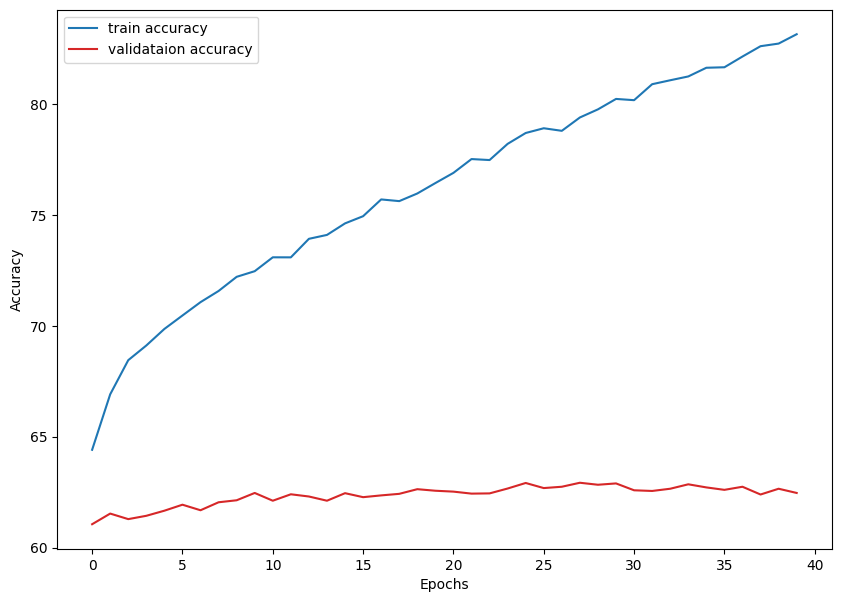

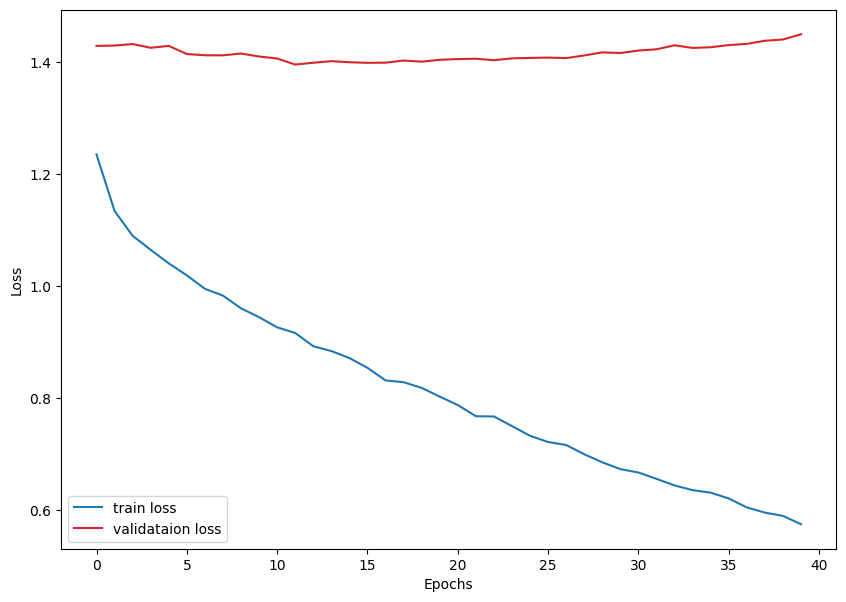

In [12]:
# ------------------------  OLD CODE ------------------------------
!pip install torchsummary
from torchsummary import summary

input_shape = (3, 32, 32)  # CIFAR100 

# EfficientNet-B0
opt_decay = 0.0013     
learning_rate = 1.5e-4  

# # ResNet18
# opt_decay = 0.0002
# learning_rate = 8e-4

epochs = 50
max_lr = 1.5e-3
batch_size = 512
train_loader, val_loader = load_data(batch_size)

optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                      weight_decay=opt_decay)
## Here is what happens to weights when set SGD(w_decay=opt_decay)
#  weight = weight - learning_rate * (gradient + weight_decay * weight)

criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                          steps_per_epoch=len(train_loader))

summary(model,input_shape)

import time

train_loss, valid_loss = [],[]
train_acc, valid_acc = [],[]
highest_acc = 0.0
best_epoch = 0
patience = 12
early_stop_counter = 0

for epoch in range(epochs):
  print(f"[INFO]: Epoch {epoch+1} of {epochs}")

  train_epoch_loss, train_epoch_acc = train(model,train_loader,optimizer,
                                            criterion,scheduler, device)

  train_loss.append(train_epoch_loss)
  train_acc.append(train_epoch_acc)

  start_time = time.time()
  valid_epoch_loss, valid_epoch_acc = validate(model,val_loader,
                                               criterion, device)
  end_time = time.time()
  inference = end_time - start_time

  valid_loss.append(valid_epoch_loss)
  valid_acc.append(valid_epoch_acc)

  print(f"\nTraining loss: {train_epoch_loss:.2f}, Training acc: {train_epoch_acc:.1f}")
  print(f"Validation loss: {valid_epoch_loss:.2f}, Validation acc: {valid_epoch_acc:.1f}")
  print(f"Inference time: {inference:.2f} seconds")
  print('-'*50)

  if valid_epoch_acc > highest_acc:
    highest_acc = valid_epoch_acc
    best_epoch = epoch + 1
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= patience:
      print(f"Early stopping at epoch {epoch + 1} as validation accuracy did not improve.")
      break


save_plots(train_acc,valid_acc,train_loss,valid_loss)
print(f"Highest validation accuracy achieved: {highest_acc:.1f} at epoch {best_epoch}")


####Save Model

In [13]:
# # ONLY RUN THIS BLOCK IF DOING WEIGHT PRE-TRAINING
# from google.colab import drive
# drive.mount('/content/drive')
# save_path = '/content/drive/My Drive/Colab Notebooks/Enet_Stage2.pth'
# torch.save(model.state_dict(), save_path)